In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from proj_helper import Helper
import joblib

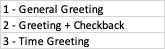

In [9]:
chat_data = pd.read_excel('chatdata.xlsx', header=0) 

In [10]:
chat_data.head()

,Chat,Group
0,Hi!,1
1,Hi! I'm,1
2,Hi My name is,1
3,"Hello, I'm",1
4,Good Morning!,3


In [11]:
chat_data['Group'].value_counts()

1    34
2    33
3    27
5    24
4    13
Name: Group, dtype: int64

In [12]:
item = Helper()
item.preprocess("Heyy I'm Mudith")

for row in range(len(chat_data['Chat'])):
    chat_data['Chat'][row] = item.preprocess(chat_data['Chat'][row])

chat_data['Chat'].head()

<ipython-input-12-b33db97d66db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chat_data['Chat'][row] = item.preprocess(chat_data['Chat'][row])


0                 hi !
1       hi ! -PRON- be
2    hi -PRON- name be
3    hello , -PRON- be
4       Good Morning !
Name: Chat, dtype: object

In [13]:
x_train,x_test,y_train,y_test=train_test_split(chat_data['Chat'],chat_data['Group'],test_size=0.2)

In [14]:
pipe = Pipeline([('Tfid_Vect',TfidfVectorizer()),('MNB', MultinomialNB(alpha=0.1))])
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
y_true = y_test

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.71      0.83         7
           2       0.60      0.75      0.67         4
           3       0.83      1.00      0.91         5
           4       0.50      0.33      0.40         3
           5       0.78      0.88      0.82         8

    accuracy                           0.78        27
   macro avg       0.74      0.73      0.73        27
weighted avg       0.79      0.78      0.77        27



In [ ]:
# save the model to disk
filename = 'Group_model.sav'
joblib.dump(pipe, filename)

In [ ]:
# load the model from disk
# loaded_model = joblib.load("Group_model.sav")

In [ ]:
item.preprocess("Hi There")

In [ ]:
# loaded_model.predict([item.preprocess("Hi There")])